## Import Library's

In [1]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Twitter credentials

In [2]:

consumer_key = "xxxxxxxxxxxxxxxx"
consumer_secret = "xxxxxxxxxxxxxxxx"
access_token = "xxxxxxxxxxxxxxxx"
access_token_secret = "xxxxxxxxxxxxxxxx"

## Credentials

In [120]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)

# Creating the API object while passing in auth information
api = tweepy.API(auth, wait_on_rate_limit=True, timeout=600) 

## set two date variables for date range


In [121]:
start_date = '2020-05-07'
end_date = '2020-05-08'

## Create file paths for the CSV files

In [122]:
covid_tweets = "Data/covid_data.csv"

## Twitter Search Data

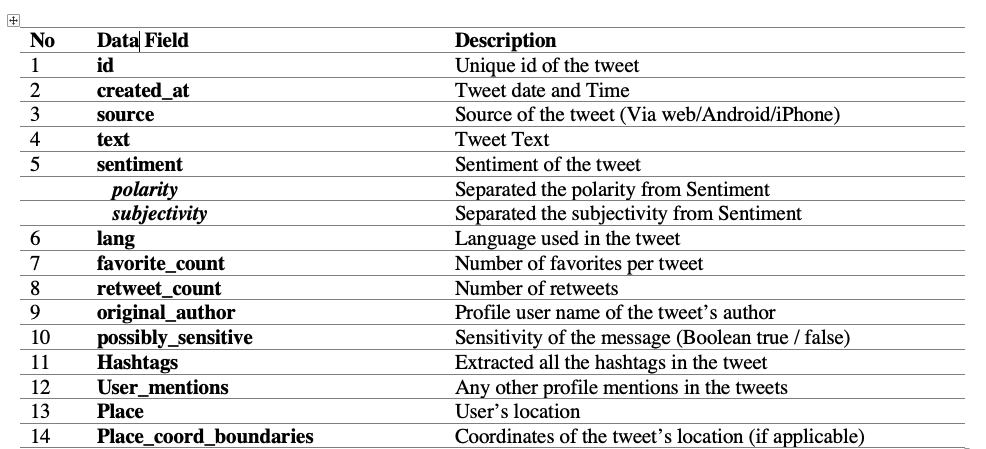

In [123]:
from IPython.display import Image
Image("img/twitter_search_data.png")

In [124]:
#columns of the csv file
COLS = ['id', 'created_at', 'original_text','clean_text', 'sentiment', 'lang', 'screen_name', 'location']

## Handle Emoticons and Emojis

In [125]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

## Clean Data

In [126]:
def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
#after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
#replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
#remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
#filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
#looping through conditions
    for w in word_tokens:
#check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)return tweet

## Extract Tweets

In [127]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    
    flag = 0
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date, until=end_date).pages():
        for status in page:
            new_entry = []
            status = status._json

            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue

            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]

                continue



            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(status['text'])

            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment


            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['text'],filtered_tweet, Sentiment, status['lang']]

            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])


            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)

            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            if flag == 0:
                single_tweet_df.to_csv(file, sep=',', index=False, encoding="utf-8")
                flag = 1
            else:
                with open(file, 'a', encoding='utf-8') as f:
                    single_tweet_df.to_csv(f, sep=',', index=False, header=False, encoding="utf-8")
            
#             df = df.append(single_tweet_df, ignore_index=True)
#             csvFile = open(file, 'a' ,encoding='utf-8')
            
#     df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [ ]:
#declare keywords as a query 
covid19_keywords = '#covid19 OR #covid OR #corona OR #coronaviras OR #corona-virus OR #covid19-virus OR #sarscov2'

#call main method passing keywords and file path
write_tweets(covid19_keywords,  covid_tweets)